In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from edu.javerianacali.create_dataset import CreateDataSet
from edu.javerianacali.model.ccn_model import ConvulationalNeuralNetwork
from edu.javerianacali.model.logistic_regression_model import LogisticRegressionModel
from edu.javerianacali.process_images import ProcessImages
from edu.javerianacali.data_aumentation import DataAugmentation
from edu.javerianacali.model.svm_model import SupportVectorMachineModel
directorio = "/home/maucasco/Documents/maestria/proyecto_grado/pujc-advocato-filter-project-mngr/assets"


2024-05-16 20:32:44.235038: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-16 20:32:44.325218: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-16 20:32:44.676300: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-16 20:32:46.145609: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# AUMENTO DE DATOS

In [ ]:

from edu.javerianacali.data_aumentation import DataAugmentation

DataAugmentation().augment_images(directorio+'/poquitas'

)

# PROCESAR INAGENES PARA MODELOS DE APRENDIZAJE SUPERVISADO

In [ ]:
path=directorio+'/poquitas'
archivos = os.listdir(path)
for archivo in archivos:
    if archivo.endswith(".JPG") or archivo.endswith(".jpg")  or archivo.endswith(".png"):
        ruta_imagen = os.path.join(path, archivo)
        titulos = ["Ori", "SinTex","Sinsomb", archivo]
        imagenes = ProcessImages().procesar_imagen(ruta_imagen,archivo,directorio,100,100)
        ProcessImages().mostrar_imagenes(titulos, imagenes)



In [ ]:
create_dataset = CreateDataSet().create_dataset(directorio)
LogisticRegressionModel().prepare_dataset(directorio)
print(create_dataset[1])
LogisticRegressionModel().train_model(create_dataset[0], create_dataset[1])



In [ ]:


from edu.javerianacali.model.svm_model import SupportVectorMachineModel
create_dataset = CreateDataSet().create_dataset(directorio)
features, labels = create_dataset[0], create_dataset[1]
print(features)
SupportVectorMachineModel().train_svm_model(features, labels)


# RED NEURONAL

In [ ]:
path=directorio
archivos = os.listdir(path)
for archivo in archivos:
    if archivo.endswith(".JPG") or archivo.endswith(".jpg"):
        ruta_imagen = os.path.join(path, archivo)
        titulos = ["Ori", "SinTex","Sinsomb", archivo]
        imagenes = ProcessImages().procesar_imagen(ruta_imagen,archivo,directorio,500,500)
       # ProcessImages().mostrar_imagenes(titulos, imagenes)



In [ ]:

CreateDataSet().create_dataset_cnn(directorio)

In [2]:
directorio = "/home/maucasco/Documents/maestria/proyecto_grado/pujc-advocato-filter-project-mngr/assets"
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from edu.javerianacali.create_dataset import CreateDataSet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt
        # Crea un generador de datos de imagen con normalización500




datagen = ImageDataGenerator(rescale=1./255,shear_range=0.15,zoom_range=0.15,horizontal_flip=True)
print(directorio
+'/train')
# Carga las imágenes desde el directorio
generator = datagen.flow_from_directory(
directorio+'/train',
target_size=(500, 500),  
batch_size=32,
class_mode='categorical' )


# Generador de datos de validación
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    directorio+'/test',
    target_size=(500, 500),
    batch_size=32,
    class_mode='categorical'
)


/home/maucasco/Documents/maestria/proyecto_grado/pujc-advocato-filter-project-mngr/assets/train
Found 499 images belonging to 2 classes.
Found 215 images belonging to 2 classes.


/home/maucasco/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 498, 498, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 249, 249, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 247, 247, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 123, 123, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 121, 121, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 460800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 460800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    58,982,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,076,034 (225.36 MB)

 Trainable params: 59,076,034 (225.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


/home/maucasco/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 105s 6s/step - accuracy: 0.7258 - loss: 6.5845
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 107s 6s/step - accuracy: 0.7782 - loss: 0.3429
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 96s 5s/step - accuracy: 0.8955 - loss: 0.2592
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 84s 5s/step - accuracy: 0.9143 - loss: 0.2991
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 85s 5s/step - accuracy: 0.9193 - loss: 0.2219
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 84s 5s/step - accuracy: 0.9429 - loss: 0.1893
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 84s 5s/step - accuracy: 0.9477 - loss: 0.1715
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 85s 5s/step - accuracy: 0.9505 - loss: 0.1550
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 86s 5s/step - accuracy: 0.9403 - loss: 0.1886
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 84s 5s/step - accuracy: 0.9340 - loss: 0.1632
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 86s 5s/step - accuracy: 0.9413 - loss: 0.1627
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 84s 5s/step - accuracy: 0.9359 - loss: 0.181

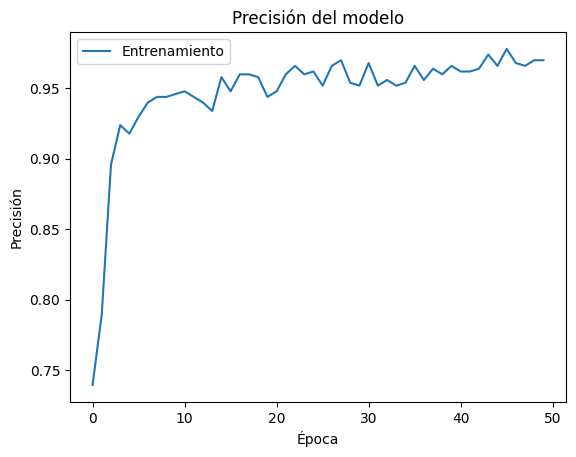

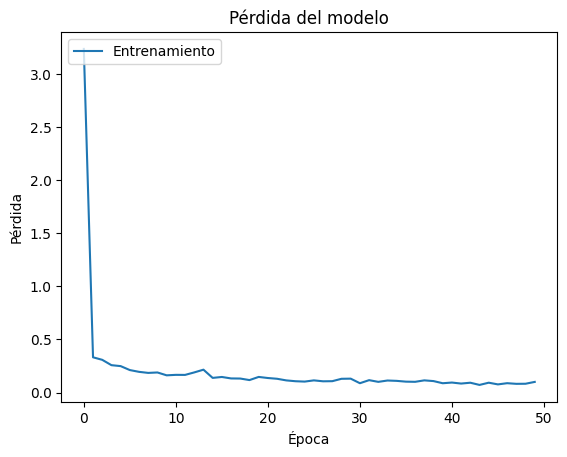

In [3]:
import tensorflow as tf
from keras.layers import Dropout
from keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
modelo = Sequential([
            Conv2D(32, (3,3), activation='relu',padding="valid", input_shape=(500, 500, 3)),
            MaxPooling2D(pool_size=(2,2)),
            Conv2D(64, (3,3), activation='relu',padding="valid"),
            MaxPooling2D(pool_size=(2,2)),
            Conv2D(128, (3, 3), activation='relu',padding="valid"), # Capa adicional
            MaxPooling2D((2, 2)),
            Flatten(),
            Dropout(0.5),  # Capa de abandono para regularización
          
            Dense(128, activation='relu'),
            Dense(2, activation='softmax'),  # Añade la capa Dense según el tamaño de salida de Flatten
        ])


# Aquí puedes imprimir la forma de la salida para ver cuántas neuronas necesita la siguiente capa Dense
modelo.summary()


modelo.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),  # Ajustar la tasa de aprendizaje
    loss='categorical_crossentropy',  
    metrics=['accuracy'])


historial = modelo.fit(
    generator,
    epochs=50,  # Aumentar el número de épocas
    batch_size=32
)

# Gráficos de precisión y pérdida
plt.plot(historial.history['accuracy']) # Precisión de validación
plt.title('Precisión del modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()

plt.plot(historial.history['loss']) # Pérdida de validación
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')# Añade la capa Dense según el tamaño de salida de Flatten


plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()

In [ ]:
plot_model(modelo, to_file='/home/maucasco/Documents/maestria/proyecto_grado/pujc-advocato-filter-project-mngr/modelo1_cnn.png', show_shapes=True, show_layer_names=True)

16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step
Confusion Matrix


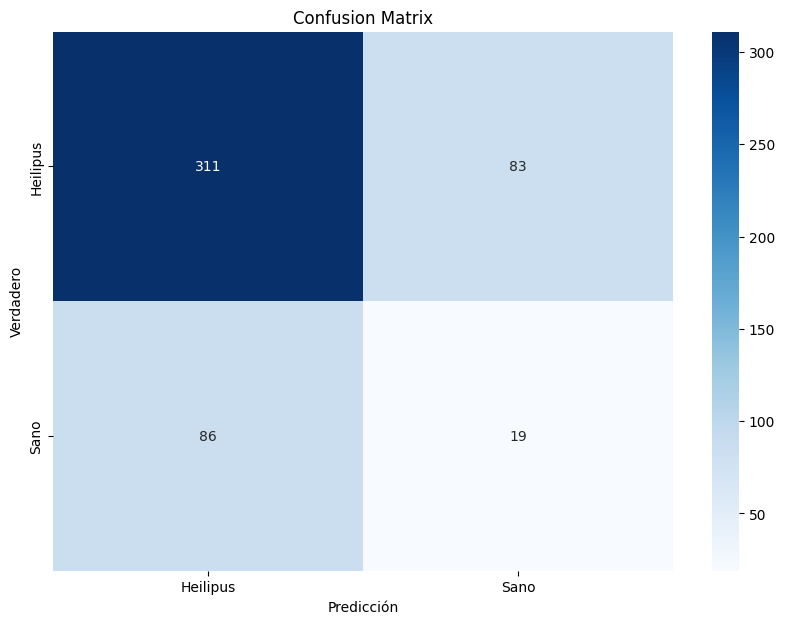

Classification Report
{'0': {'precision': 0.783375314861461, 'recall': 0.7893401015228426, 'f1-score': 0.786346396965866, 'support': 394.0}, '1': {'precision': 0.18627450980392157, 'recall': 0.18095238095238095, 'f1-score': 0.18357487922705312, 'support': 105.0}, 'accuracy': 0.6613226452905812, 'macro avg': {'precision': 0.48482491233269126, 'recall': 0.4851462412376118, 'f1-score': 0.4849606380964595, 'support': 499.0}, 'weighted avg': {'precision': 0.6577328608914377, 'recall': 0.6613226452905812, 'f1-score': 0.6595107068605045, 'support': 499.0}}


,precision,recall,f1-score,support
0,0.783375,0.789340,0.786346,394.000000
1,0.186275,0.180952,0.183575,105.000000
accuracy,0.661323,0.661323,0.661323,0.661323
macro avg,0.484825,0.485146,0.484961,499.000000
weighted avg,0.657733,0.661323,0.659511,499.000000


In [4]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
# Evaluar el modelo en el conjunto de prueba o validación
# Asumiendo que tienes `validation_generator` como tu conjunto de validación/test
y_pred = modelo.predict(generator)
y_test = generator.classes  # Etiquetas verdaderas
y_pred = np.argmax(y_pred, axis=1)  # Convertir predicciones a etiquetas

# Matriz de confusión
print("Confusion Matrix")
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Obtener nombres de clases desde el generador
class_names = list(validation_generator.class_indices.keys())

# Visualización de la matriz de confusión
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Confusion Matrix')
plt.show()


# Informe de clasificación

report = classification_report(y_test, y_pred, output_dict=True)
print("Classification Report")
print(report)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv('classification_report_cnn.csv', index=True)

cm = sns.light_palette("blue", as_cmap=True)
styled_df = report_df.style.background_gradient(cmap=cm)
display(styled_df)


In [ ]:
# Si y_pred es unidimensional, no necesitas indexarlo con [:, 1]
if y_pred.ndim == 1:
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Visualización de la curva ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa Falsos Positivos')
    plt.ylabel('Tasa de falsos Negativos')
    plt.title('Curva ROC ')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
from keras.models import Model
import matplotlib.pyplot as plt

# Crear un modelo que devuelva las activaciones de la primera capa convolucional
activation_model = Model(inputs=modelo.input, outputs=modelo.layers[0].output)

# Obtener las activaciones de la primera capa convolucional para la primera imagen en el conjunto de entrenamiento
activations = activation_model.predict(validation_generator[0][0][0].reshape(1, 500, 500, 3))

# Visualizar las activaciones de los primeros 6 filtros
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(activations[0, :, :, i], cmap='viridis')
    ax.axis('off')
plt.show()

In [ ]:
from sklearn.model_selection import KFold
import numpy as np

# Suponiendo que tienes todas tus imágenes y etiquetas cargadas en X e Y
# X, Y = load_data()

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True)

fold_no = 1
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]

    # Crear el modelo de CNN aquí
    modelo = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(100, 130, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(2, activation='softmax')
    ])

    modelo.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

    # Entrenar el modelo
    modelo.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=10, batch_size=32)

    # Evaluar el modelo
    scores = modelo.evaluate(X_val, Y_val, verbose=0)
    print(f'Score for fold {fold_no}: {modelo.metrics_names[1]} of {scores[1]*100}%')
    
    fold_no += 1

In [5]:
# Guardar el modelo en un archivo
modelo.save('/home/maucasco/Documents/maestria/proyecto_grado/pujc-advocato-filter-project-mngr/modelo/modelo_cnn.h5')


In [ ]:
# Cargar el modelo desde un archivo
from keras.models import load_model
modelo = load_model('/home/maucasco/Documents/maestria/proyecto_grado/pujc-advocato-filter-project-mngr/modelo/modelo_cnn.h5')

In [ ]:

from keras.preprocessing import image
import numpy as np
# Load and preprocess the image
img_path = '/home/maucasco/Downloads/images.jpeg'
imagen = cv2.imread(img_path)[100:, :]
imagen_sin_texto,aguacate_solo, redimenciada = ProcessImages().procesar(imagen,500,500)
img_array = image.img_to_array(redimenciada)


plt.imshow(redimenciada, cmap='gray')
plt.show()
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Make predictions
predictions = modelo.predict(img_array)
print(predictions)